# Pyem

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
#from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,10


from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *

In [3]:
from external.pyem.project import project
from external.pyem.pyem import star
from external.pyem.pyem import vop
from numpy.fft import fftshift
from pyfftw.builders import irfft2

In [4]:
# Arguments for project:
# p : dataframe of star file : df = star.parse_star(args.input, keep_index=False); star.augment_star_ucsf(df);
#     Here, input is the STAR file with particle metadata



### The volume

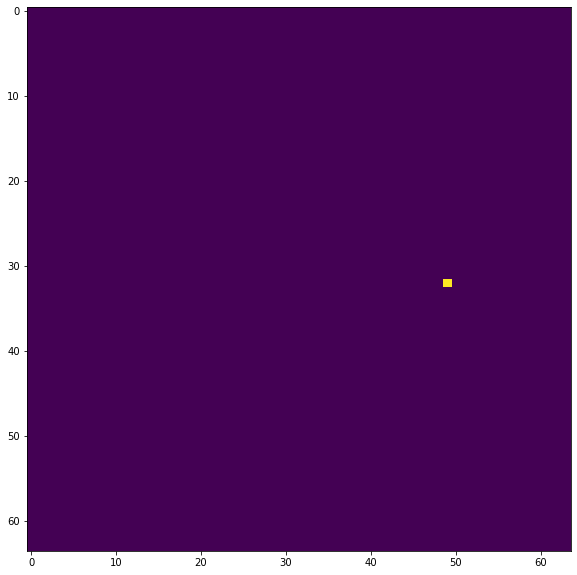

In [209]:
nx = 64
dx = 0.2

v = np.zeros([nx,nx,nx])
v[32,32,49] = 1

mip_x(v)

In [210]:
# f3d : Fourier volume (centred, Nyquist-limited, zero-padded (pfac=2), normalized (normfft=1) interpolation-ready 3D Fourier transform)

pfac = 1
f3d = vop.vol_ft(v, pfac=pfac, threads=1)

In [211]:
f3d.shape

(67, 67, 33)

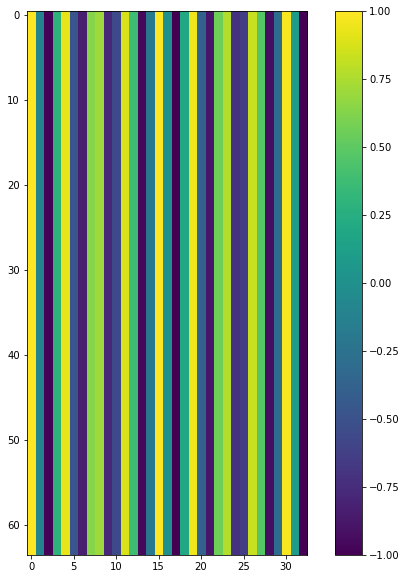

In [212]:
plt.imshow(np.real(f3d[33,2:66,:])); plt.colorbar()

In [213]:
n = v.shape[0]
nhalf = n // 2
x, y, z = np.meshgrid(*[np.arange(-nhalf, nhalf)] * 3, indexing="xy")

In [214]:
vf = np.fft.rfftn(v)
vf.shape

(64, 64, 33)

In [215]:
ar = np.arange(4,7)
np.pad(ar, 3, "constant")

array([0, 0, 0, 4, 5, 6, 0, 0, 0])

### Parameters from the star file
https://relion.readthedocs.io/en/release-3.1/Reference/Conventions.html?highlight=star#star-format

In [216]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)

In [230]:
dfiter = df.iterrows()
i, p = next(dfiter)
#i, p = next(dfiter)

#p["rlnVoltage"] = 0
#p["rlnSphericalAberration"]
p[star.Relion.ORIGINX] = 0
p[star.Relion.ORIGINY] = 0

# These don't seem to make any difference here. These replaced rlnOriginX and rlnOriginY (pixels) in Relion 3.1
p[star.Relion.ORIGINXANGST] = 0
p[star.Relion.ORIGINYANGST] = 0

p[star.Relion.ANGLEROT] = 90  # Around the z axis (first axis)
p[star.Relion.ANGLETILT] = 0 # Around the new y axis 
p[star.Relion.ANGLEPSI] = 0 # Arond the new z axis


p["rlnSphericalAberration"] = 0
p["rlnAmplitudeContrast"] = 0

p[star.Relion.DEFOCUSU] = 0
p[star.Relion.DEFOCUSV] = 0
p[star.Relion.DEFOCUSANGLE] = 0

pzero = p.copy()
#pzero

Bogdan2


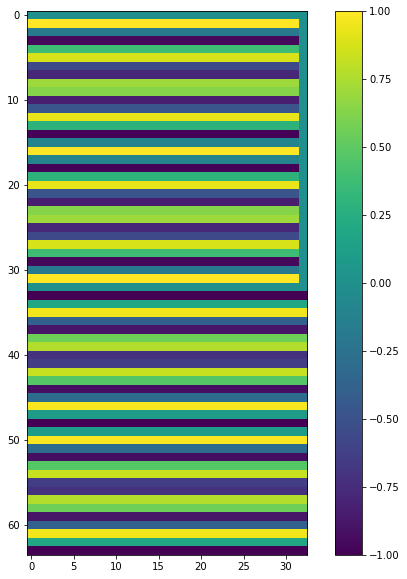

In [231]:
#pfac = 2

size = (f3d.shape[0] - 3) // pfac
#size = f3d.shape[0]

sz = (f3d.shape[0] - 3) // pfac
#sz = size
apix = star.calculate_apix(df) * np.double(size) / sz
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)

f2d = project(f3d, p, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)


ift = irfft2(f2d.copy(), threads=1, planner_effort="FFTW_ESTIMATE", auto_align_input=True, auto_contiguous=True)
proj = fftshift(ift(f2d.copy(), np.zeros(ift.output_shape, dtype=ift.output_dtype)))

#plt.imshow(proj); plt.colorbar()

In [232]:
f3d.shape

(67, 67, 33)

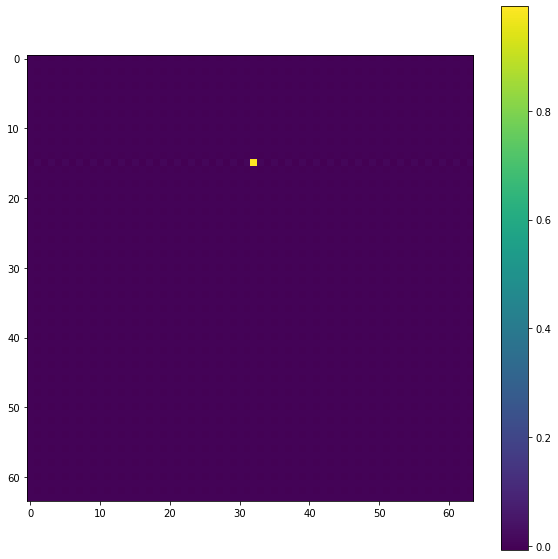

In [233]:
plt.imshow(proj); plt.colorbar()
#plt.imshow(np.log(np.abs(proj)+1e-15)); plt.colorbar()

In [234]:
print(np.max(proj))
print(np.min(proj))

0.9921874999999993
-0.007812500000000363


In [235]:
f2d.shape

(64, 33)

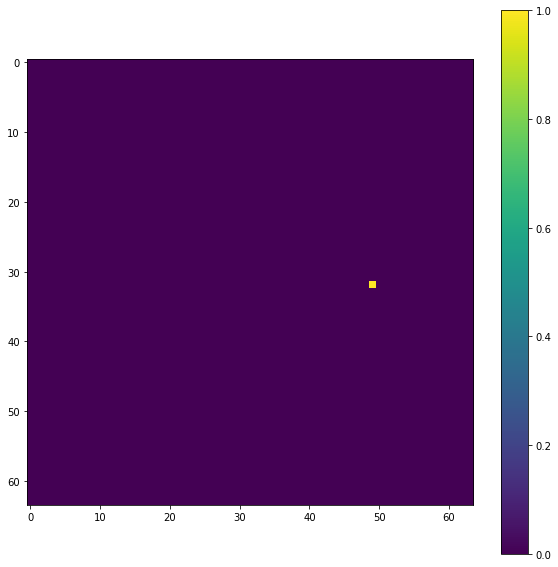

In [222]:
mip_x(v); plt.colorbar()

0.6975192550192576

In [224]:
np.max(v)

1.0

In [225]:
proj.shape

(64, 64)

In [226]:
v.shape

(64, 64, 64)

## Fourier point source

Bogdan2


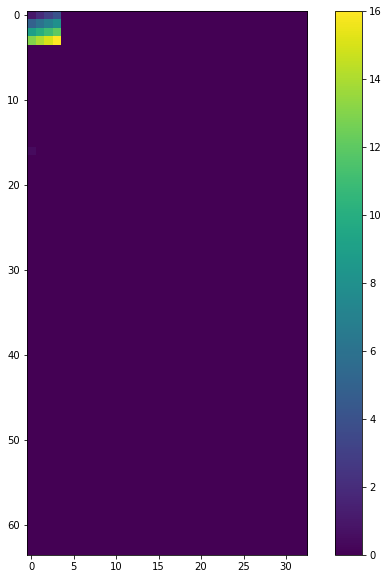

In [54]:
vf = np.zeros([67,67,33])
vf[33, 33, 0] = 0.5
vf[33, 49, 0] = 0.5

vf[33, 33:37, 0:4] = np.arange(1,17).reshape(4,4)

#size = 64
pfac = 1

size = (vf.shape[0] - 3) // pfac

sz = (vf.shape[0] - 3) // pfac
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)

p1 = pzero.copy()
p1[star.Relion.ANGLEROT] = 0
p1[star.Relion.ANGLETILT] = 0
p1[star.Relion.ANGLEPSI] = 0

p1[star.Relion.ORIGINX] = 0
p1[star.Relion.ORIGINY] = 0

f2d = project(vf, p1, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)
#plt.imshow(np.real(f2d)); plt.colorbar()

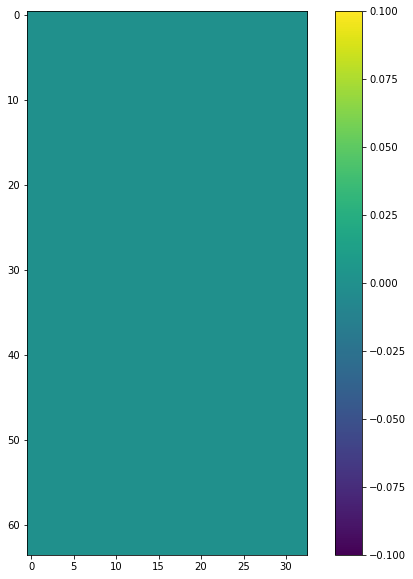

In [55]:
plt.imshow(np.imag(f2d)); plt.colorbar()

Bogdan2


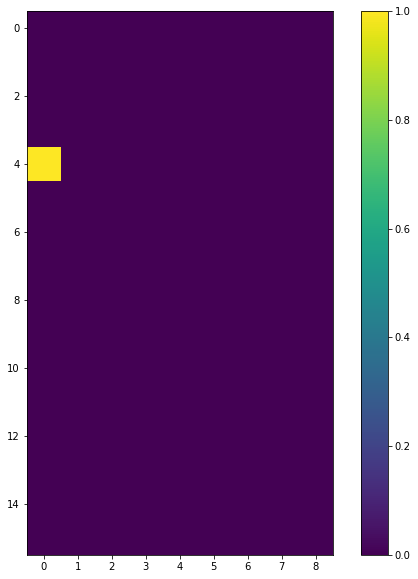

In [36]:
vf = np.zeros([19,19,9], dtype=np.complex128)
vf[9, 13, 0] = 1 + 1j

size = 16
pfac = 1

size = (vf.shape[0] - 3) // pfac

sz = (vf.shape[0] - 3) // pfac
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)

p1 = pzero.copy()
p1[star.Relion.ANGLEROT] = 0

p1[star.Relion.ANGLETILT] = 0
p1[star.Relion.ANGLEPSI] = 0

p1[star.Relion.ORIGINX] = 0
p1[star.Relion.ORIGINY] = 0

f2d = project(vf, p1, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)


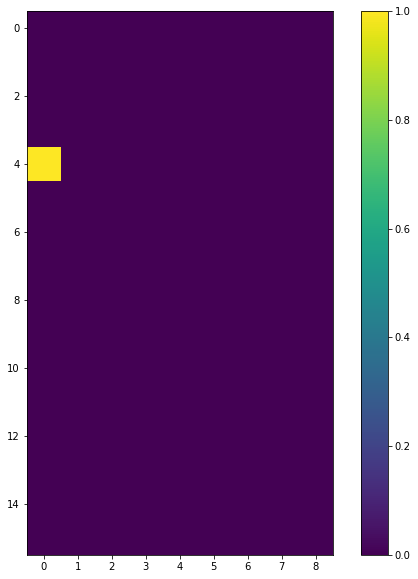

In [41]:
plt.imshow(np.real(f2d)); plt.colorbar()

In [38]:
np.max(np.abs(f2d))

1.4142135623730951